In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN

In [2]:
dataset = pd.read_csv('corona_daily.csv').values
# neural network의 입력은 2d array만 가능
corona_data = dataset[:,3:4]
corona_data.shape
# dataset의 4번째 열은 confirmed(확진자) 수로 누적된 값이기 때문에, 점점 증가한다.

(115, 1)

In [3]:
from sklearn.model_selection import train_test_split
train_data,test_data = train_test_split(corona_data,test_size=0.2,shuffle=False)
# RNN은 순차데이터(순서가 있는 데이터)를 다루기 때문에 순서가 바뀌면 안됨
# shuffle = False로 설정하면 입력된 data를 섞지 않는다. (default: True)
# 위를 실행하면, corona_data의 앞쪽 80%가 train_data, 그 뒤 20%가 test_data가 된다.

In [4]:
train_data.shape, test_data.shape

((92, 1), (23, 1))

In [5]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range=(0,1))
# MinMaxScaler(feature_range=(a,b)): 입력을 최소값이 a이고 최대값이 b가 되도록 변형함
sc.fit(train_data)
train_sc = sc.transform(train_data)
# training data의 최대값이 1이 되며,
# test data의 값은 training data 이후 값으로 더 큰 값이므로, 1보다 큰 값을 갖는다.
test_sc = sc.transform(test_data)

In [6]:
# RNN에 적용할 수 있는 형태로 변경하는 함수
# num_past만큼의 과거 데이터(X), 다음 데이터(y)
def create_dataset(dataset,num_past):
  # 비어있는 X,y list 생성
  X = []
  y = []
  # n개(len(dataset))의 데이터가 입력되면, n-num_past만큼의 X,y 쌍이 생성된다
  for i in range(len(dataset)-num_past):
    # X는 현재 index i부터 num_past만큼의 data
    X_tmp = dataset[i:i+num_past]
    # y는 X 이후의 data
    y_tmp = dataset[i+num_past]

    # list에 X_tmp와 y_tmp를 추가한다.
    X.append(X_tmp)
    y.append(y_tmp)

  return np.array(X),np.array(y)

In [7]:
# training과 test dataset을 X와 y로 분리
past = 3
X_train,y_train = create_dataset(train_sc,past)
X_test,y_test = create_dataset(test_sc,past)

In [8]:
# 분리된 결과를 확인
print(train_sc.shape)
# 분리 전 training data.shape: (92,1)
# 분리 후 → X_train.shape, y_train.shape ??
print(X_train.shape, y_train.shape)
# X_train은 위 create_dataset에 의해 3d array가 됨

(92, 1)
(89, 3, 1) (89, 1)


- RNN 입력의 shape은 반드시 **(sample의 수, 특징의 수, 과거 데이터의 수)**의 형태여야 한다.
- 현재 X_train과 X_test는 **(sample의 수, 과거 데이터의 수, 1)**이므로 RNN 입력을 위한 shape으로 변경해야 한다.
- 위 데이터에서 confirmed 한개의 열만 추출하여 사용하므로, 특징의 수는 1이다.

In [9]:
# training data의 수
num_train = X_train.shape[0]
# 과거 데이터의 수
num_past = X_train.shape[1]
# 특징의 수
num_feature = X_train.shape[2]

# test data의 수
num_test = X_test.shape[0]

In [10]:
# X_train을 2d array, y_train을 1d array로 변경
X_train_rnn = X_train.reshape(num_train,num_feature,num_past)
y_train_rnn = y_train.ravel()
X_test_rnn = X_test.reshape(num_test,num_feature,num_past)
y_test_rnn = y_test.ravel()
print(X_train_rnn.shape,y_train_rnn.shape,X_test_rnn.shape,y_test_rnn.shape)

(89, 1, 3) (89,) (20, 1, 3) (20,)


In [11]:
model_RNN = Sequential([
    SimpleRNN(10,input_shape=(1,num_past)),
    # SimpleRNN(node의 수, input_shape)
    # input_shape = (X의 차원, 예측을 위해 사용되는 과거 데이터의 수)
    Dense(1,activation='linear')
    # 본 문제는 하나의 연속된 값을 예측하는 모델이므로, regression model에 해당한다.
    # regression model은 output layer의 node 수가 1개이며, activation은 linear를 사용한다.
    # linear activation은 활성화 함수를 거치지 않고 결과를 그대로 내보낸다는 의미이다.
])

In [12]:
model_RNN.compile(optimizer='adam',loss='mse')
# regression model을 학습할 때, loss는 주로 mse를 많이 사용한다.

In [13]:
learning_result = model_RNN.fit(X_train_rnn,y_train_rnn,batch_size=1,epochs=100)

Epoch 1/100
89/89 [==============================] - 1s 2ms/step - loss: 0.6560
Epoch 2/100
89/89 [==============================] - 0s 2ms/step - loss: 0.0602
Epoch 3/100
89/89 [==============================] - 0s 2ms/step - loss: 0.0291
Epoch 4/100
89/89 [==============================] - 0s 2ms/step - loss: 0.0196
Epoch 5/100
89/89 [==============================] - 0s 2ms/step - loss: 0.0123
Epoch 6/100
89/89 [==============================] - 0s 2ms/step - loss: 0.0070
Epoch 7/100
89/89 [==============================] - 0s 2ms/step - loss: 0.0038
Epoch 8/100
89/89 [==============================] - 0s 2ms/step - loss: 0.0019
Epoch 9/100
89/89 [==============================] - 0s 2ms/step - loss: 9.9552e-04
Epoch 10/100
89/89 [==============================] - 0s 2ms/step - loss: 5.5938e-04
Epoch 11/100
89/89 [==============================] - 0s 2ms/step - loss: 3.5930e-04
Epoch 12/100
89/89 [==============================] - 0s 2ms/step - loss: 2.8441e-04
Epoch 13/100
89/89 [=

In [14]:
y_train_pred = model_RNN.predict(X_train_rnn)
y_test_pred = model_RNN.predict(X_test_rnn)

1/1 [==============================] - 0s 27ms/step


In [16]:
# predict의 결과는 MinMaxScaler된 값을 사용하므로, 실제 단위와는 다르므로, 기존의 scale로 다시 되돌린다.
# MinMaxScaler의 역변환
y_train_pred_inv = sc.inverse_transform(y_train_pred)
y_test_pred_inv = sc.inverse_transform(y_test_pred)

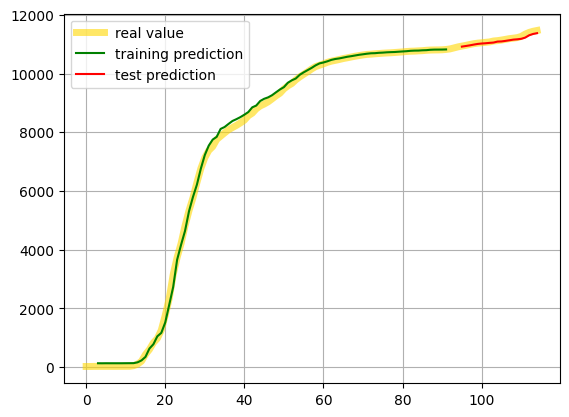

In [31]:
# 결과 시각화 하기
# 1. source data plot (confirmed value)
# 2. training prediction plot (y_train_pred_inv)
# 3. test prediction plot (y_test_pred_inv)

plt.plot(corona_data,linewidth=5,alpha=0.6,label='real value',color='gold')
# np.arange(a,b,c): a부터 b까지 c간격으로 1d array 생성 (b는 제외)

train_start_ind = num_past
train_end_ind = num_past + len(y_train_pred_inv)
x_train_axis = np.arange(train_start_ind,train_end_ind,1)
plt.plot(x_train_axis,y_train_pred_inv,color='green',label='training prediction')

test_start_ind = train_end_ind + num_past
test_end_ind = test_start_ind + len(y_test_pred_inv)
x_test_axis = np.arange(test_start_ind,test_end_ind,1)
plt.plot(x_test_axis,y_test_pred_inv,color='red',label='test prediction')

plt.legend()
plt.grid()